In [1]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate


In [2]:
WINDOW = 8 # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
INTERVAL = '1y'     # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
symbol = 'FB'      # Symbol of the desired stock
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'CCI', 'VORTEX']
ROWS_TO_PREDICT = 32
# one day 16 rows of data

In [3]:
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-02-10 04:00:00-05:00,212.250000,212.610000,212.200000,212.200000,212.200000,0
2020-02-10 06:00:00-05:00,212.080000,212.610000,212.080000,212.300000,212.300000,0
2020-02-10 07:00:00-05:00,212.030000,212.400000,212.030000,212.310000,212.310000,0
2020-02-10 08:00:00-05:00,212.280000,212.400000,212.010100,212.101200,212.101200,0
2020-02-10 09:00:00-05:00,212.200000,212.200000,211.500000,211.540000,211.540000,0
...,...,...,...,...,...,...
2021-02-09 08:00:00-05:00,265.794700,266.580000,265.610000,265.850000,265.850000,0
2021-02-09 09:00:00-05:00,265.950000,266.720000,265.310000,266.410000,266.410000,0
2021-02-09 09:30:00-05:00,266.440002,273.390015,265.750000,272.404999,272.404999,5668204


In [4]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)

,open,high,low,close,Adj Close,volume
Datetime,,,,,,
2020-02-10 04:00:00-05:00,212.250000,212.610000,212.200000,212.200000,212.200000,0
2020-02-10 06:00:00-05:00,212.080000,212.610000,212.080000,212.300000,212.300000,0
2020-02-10 07:00:00-05:00,212.030000,212.400000,212.030000,212.310000,212.310000,0
2020-02-10 08:00:00-05:00,212.280000,212.400000,212.010100,212.101200,212.101200,0
2020-02-10 09:00:00-05:00,212.200000,212.200000,211.500000,211.540000,211.540000,0
2020-02-10 09:30:00-05:00,211.520004,213.800003,210.914505,213.279999,213.279999,2938100
2020-02-10 10:30:00-05:00,213.279999,213.779999,212.199997,212.500000,212.500000,1377017
2020-02-10 11:30:00-05:00,212.490204,212.628998,211.800003,212.050003,212.050003,1034574
2020-02-10 12:30:00-05:00,212.041107,212.619995,211.850006,212.360001,212.360001,664739


<AxesSubplot:xlabel='Datetime'>

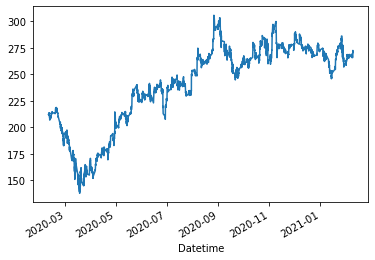

In [5]:
data['close'].plot()

In [6]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = pd.concat([data, ind_data], axis=1)
    # data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    # data['ema15'] = data['close'] / data['close'].ewm(ROWS_TO_PREDICT).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    # del (data['open'])
    # del (data['high'])
    # del (data['low'])
    # del (data['volume'])
    del (data['Adj Close'])

    return data

data = _get_indicator_data(data)

In [7]:
data

,open,high,low,close,volume,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,ema50,ema21,ema5
Datetime,,,,,,,,,,,,,,,,,,,,
2020-02-10 04:00:00-05:00,212.250000,212.610000,212.200000,212.200000,0,NaN,0.000000,0.000000,NaN,-0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000
2020-02-10 06:00:00-05:00,212.080000,212.610000,212.080000,212.300000,0,100.000000,0.002244,0.001246,NaN,-0.000000e+00,NaN,NaN,NaN,NaN,-66.666667,NaN,NaN,1.000233,1.000230,1.000214
2020-02-10 07:00:00-05:00,212.030000,212.400000,212.030000,212.310000,0,100.000000,0.003169,0.002034,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-100.000000,NaN,NaN,1.000185,1.000180,1.000158
2020-02-10 08:00:00-05:00,212.280000,212.400000,212.010100,212.101200,0,31.385804,-0.004027,-0.000019,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-107.395040,NaN,NaN,0.999407,0.999412,0.999440
2020-02-10 09:00:00-05:00,212.200000,212.200000,211.500000,211.540000,0,10.510880,-0.030183,-0.008992,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-166.666667,NaN,NaN,0.997434,0.997474,0.997686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-09 08:00:00-05:00,265.794700,266.580000,265.610000,265.850000,0,42.873625,-0.392921,-0.304535,81.544191,7.093267e+09,1.416577,0.051996,40.281627,0.009400,-39.338939,1.165388,0.970250,0.996368,0.996982,0.999014
2021-02-09 09:00:00-05:00,265.950000,266.720000,265.310000,266.410000,0,48.637330,-0.343396,-0.312307,95.406360,7.093267e+09,1.364793,0.189999,54.834930,0.255895,-30.171102,1.048673,0.989270,0.998497,0.999124,1.000931
2021-02-09 09:30:00-05:00,266.440002,273.390015,265.750000,272.404999,5668204,76.256058,0.177552,-0.214335,93.642194,7.130258e+09,1.821222,5.804993,90.932919,2.485720,161.952791,0.725850,1.023532,1.020546,1.020605,1.019470


In [8]:
data.columns

Index(['open', 'high', 'low', 'close', 'volume', '14 period RSI', 'MACD',
       'SIGNAL', '14 period STOCH %K', 'MFV', '14 period ATR', 'MOM',
       '14 period MFI', 'ROC', '20 period CCI', 'VIm', 'VIp', 'ema50', 'ema21',
       'ema5'],
      dtype='object')

In [9]:
def create_class_column(row):
    if row['close_shift']-row['close'] > 1.2:
        return 1
    if row['close_shift'] -row['close']< -1.2:
        return -1
    else:
        return 0

In [10]:
data['close_shift'] = data.shift(-WINDOW)['close']
data

,open,high,low,close,volume,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,...,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,ema50,ema21,ema5,close_shift
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-10 04:00:00-05:00,212.250000,212.610000,212.200000,212.200000,0,NaN,0.000000,0.000000,NaN,-0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,212.360001
2020-02-10 06:00:00-05:00,212.080000,212.610000,212.080000,212.300000,0,100.000000,0.002244,0.001246,NaN,-0.000000e+00,...,NaN,NaN,NaN,-66.666667,NaN,NaN,1.000233,1.000230,1.000214,212.500000
2020-02-10 07:00:00-05:00,212.030000,212.400000,212.030000,212.310000,0,100.000000,0.003169,0.002034,NaN,0.000000e+00,...,NaN,NaN,NaN,-100.000000,NaN,NaN,1.000185,1.000180,1.000158,212.619995
2020-02-10 08:00:00-05:00,212.280000,212.400000,212.010100,212.101200,0,31.385804,-0.004027,-0.000019,NaN,0.000000e+00,...,NaN,NaN,NaN,-107.395040,NaN,NaN,0.999407,0.999412,0.999440,213.100006
2020-02-10 09:00:00-05:00,212.200000,212.200000,211.500000,211.540000,0,10.510880,-0.030183,-0.008992,NaN,0.000000e+00,...,NaN,NaN,NaN,-166.666667,NaN,NaN,0.997434,0.997474,0.997686,213.060000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-09 08:00:00-05:00,265.794700,266.580000,265.610000,265.850000,0,42.873625,-0.392921,-0.304535,81.544191,7.093267e+09,...,0.051996,40.281627,0.009400,-39.338939,1.165388,0.970250,0.996368,0.996982,0.999014,NaN
2021-02-09 09:00:00-05:00,265.950000,266.720000,265.310000,266.410000,0,48.637330,-0.343396,-0.312307,95.406360,7.093267e+09,...,0.189999,54.834930,0.255895,-30.171102,1.048673,0.989270,0.998497,0.999124,1.000931,NaN
2021-02-09 09:30:00-05:00,266.440002,273.390015,265.750000,272.404999,5668204,76.256058,0.177552,-0.214335,93.642194,7.130258e+09,...,5.804993,90.932919,2.485720,161.952791,0.725850,1.023532,1.020546,1.020605,1.019470,NaN


In [11]:
data['class_column'] = data.apply(create_class_column, axis=1)
data

,open,high,low,close,volume,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,...,14 period MFI,ROC,20 period CCI,VIm,VIp,ema50,ema21,ema5,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-10 04:00:00-05:00,212.250000,212.610000,212.200000,212.200000,0,NaN,0.000000,0.000000,NaN,-0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,212.360001,0
2020-02-10 06:00:00-05:00,212.080000,212.610000,212.080000,212.300000,0,100.000000,0.002244,0.001246,NaN,-0.000000e+00,...,NaN,NaN,-66.666667,NaN,NaN,1.000233,1.000230,1.000214,212.500000,0
2020-02-10 07:00:00-05:00,212.030000,212.400000,212.030000,212.310000,0,100.000000,0.003169,0.002034,NaN,0.000000e+00,...,NaN,NaN,-100.000000,NaN,NaN,1.000185,1.000180,1.000158,212.619995,0
2020-02-10 08:00:00-05:00,212.280000,212.400000,212.010100,212.101200,0,31.385804,-0.004027,-0.000019,NaN,0.000000e+00,...,NaN,NaN,-107.395040,NaN,NaN,0.999407,0.999412,0.999440,213.100006,0
2020-02-10 09:00:00-05:00,212.200000,212.200000,211.500000,211.540000,0,10.510880,-0.030183,-0.008992,NaN,0.000000e+00,...,NaN,NaN,-166.666667,NaN,NaN,0.997434,0.997474,0.997686,213.060000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-09 08:00:00-05:00,265.794700,266.580000,265.610000,265.850000,0,42.873625,-0.392921,-0.304535,81.544191,7.093267e+09,...,40.281627,0.009400,-39.338939,1.165388,0.970250,0.996368,0.996982,0.999014,NaN,0
2021-02-09 09:00:00-05:00,265.950000,266.720000,265.310000,266.410000,0,48.637330,-0.343396,-0.312307,95.406360,7.093267e+09,...,54.834930,0.255895,-30.171102,1.048673,0.989270,0.998497,0.999124,1.000931,NaN,0
2021-02-09 09:30:00-05:00,266.440002,273.390015,265.750000,272.404999,5668204,76.256058,0.177552,-0.214335,93.642194,7.130258e+09,...,90.932919,2.485720,161.952791,0.725850,1.023532,1.020546,1.020605,1.019470,NaN,0


In [12]:
# Class divide
data['class_column'].value_counts()

 1    1532
-1    1412
 0    1194
Name: class_column, dtype: int64

In [13]:
del (data['close'])
del (data['close_shift'])
data = data.dropna()
train_set = data.iloc[:-ROWS_TO_PREDICT]
test_set =data.iloc[-ROWS_TO_PREDICT:]

In [14]:
data['class_column'].value_counts()

 1    1513
-1    1385
 0    1160
Name: class_column, dtype: int64

In [15]:
train_set

,open,high,low,volume,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,ema50,ema21,ema5,class_column
Datetime,,,,,,,,,,,,,,,,,,,,
2020-02-10 18:00:00-05:00,213.050000,213.050000,212.950000,0,60.285099,0.110894,0.064716,73.661287,6.698538e+06,0.800513,1.500000,88.285410,0.343837,111.248046,0.960739,1.066921,1.002274,1.002108,1.001317,-1
2020-02-11 04:00:00-05:00,213.700000,213.700000,213.500000,0,68.021759,0.156736,0.083653,96.187727,6.698538e+06,0.809799,0.410001,88.285410,0.749076,195.616483,0.942667,1.084677,1.004945,1.004716,1.003599,-1
2020-02-11 06:00:00-05:00,213.700000,213.990000,210.950000,0,38.330559,0.041229,0.074972,12.209254,6.698538e+06,1.000513,-1.210000,88.285410,-0.118181,-82.983463,0.917899,0.890056,0.994091,0.993975,0.993658,-1
2020-02-11 07:00:00-05:00,211.500000,211.810000,210.880000,0,42.914735,-0.021887,0.055245,26.366559,6.698538e+06,1.039092,-0.350003,88.285410,-0.740810,-168.270564,1.070804,0.890694,0.996279,0.996231,0.996348,-1
2020-02-11 08:00:00-05:00,211.760000,211.779900,210.760000,0,37.242826,-0.120162,0.019651,4.953560,6.698538e+06,1.061942,-1.440001,88.285410,-0.743529,-190.412371,1.057852,0.919285,0.993068,0.993133,0.993929,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-05 07:00:00-05:00,266.640000,267.110000,266.550000,0,53.669507,0.034932,-0.029810,62.669874,7.085435e+09,2.922257,0.669989,20.495267,0.482794,42.252816,1.031531,0.995356,1.000770,1.002437,1.001833,1
2021-02-05 08:00:00-05:00,267.020000,267.250000,265.250000,0,47.684067,-0.001470,-0.024142,58.787035,7.085435e+09,2.767972,0.803914,30.240354,0.286554,-5.339388,1.021161,1.029934,0.997372,0.999028,0.998650,1
2021-02-05 09:00:00-05:00,265.980000,267.170000,265.850000,0,51.659776,0.020284,-0.015257,61.445936,7.085435e+09,2.761543,0.939987,37.371235,0.142730,23.644317,0.967668,1.030004,0.999740,1.001331,1.000846,1


In [16]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column']]
x = data[features]

x_train= x.iloc[:-ROWS_TO_PREDICT]
y_train= y.iloc[:-ROWS_TO_PREDICT]
x_test =x.iloc[-ROWS_TO_PREDICT:]
y_test=y.iloc[-ROWS_TO_PREDICT:]

In [17]:
classifiers = dict()

classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='best')
classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='random')
classifiers['DecisionTreeClassifier 3'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='best')
classifiers['DecisionTreeClassifier 4'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='random')
classifiers['DecisionTreeClassifier 5'] = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='best')
classifiers['DecisionTreeClassifier 6'] = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='random')
classifiers['DecisionTreeClassifier 7'] = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='best')
classifiers['DecisionTreeClassifier 8'] = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='random')

classifiers['RandomForestClassifier 1'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 2'] = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 3'] = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 4'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 5'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='entropy')
classifiers['RandomForestClassifier 6'] = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0,criterion='entropy')
classifiers['RandomForestClassifier 7'] = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0,criterion='entropy')
classifiers['RandomForestClassifier 8'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='entropy')

classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
classifiers['GradientBoostingClassifier 3'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.5)
classifiers['GradientBoostingClassifier 4'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=1)
#
classifiers['GradientBoostingClassifier 5'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers['GradientBoostingClassifier 6'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
classifiers['GradientBoostingClassifier 7'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.5)
classifiers['GradientBoostingClassifier 8'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=1)

classifiers['GradientBoostingClassifier 9'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.1)
classifiers['GradientBoostingClassifier 10'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.3)
classifiers['GradientBoostingClassifier 11'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.5)
classifiers['GradientBoostingClassifier 12'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=1)

In [18]:
def print_conf_matrix(test_y, predict, name):
    matrix = confusion_matrix(test_y, predict,  labels=[-1, 0, 1])
    print(matrix)
    ax= plt.subplot()
    sn.heatmap(matrix, annot=True, ax = ax) #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels', color='white')
    ax.set_ylabel('True labels', color='white')
    ax.set_title(f'Confusion Matrix for {name}' , color='white')
    ax.xaxis.set_ticklabels(['-1','0', '1'], color='white')
    ax.yaxis.set_ticklabels(['-1','0', '1'], color='white')
    plt.show()

def train_model(model,train_x, train_y):
    model.fit(train_x, train_y)

In [19]:
predictions= dict()
score = dict()
for k,v in classifiers.items():
    print("Calculate: ", k)
    train_model(v,x_train,y_train)
    predictions[k] = v.predict(x_test)
    score[k] = accuracy_score(y_test.values, predictions[k])
    print('Score: ',  score[k] )
    # print_conf_matrix(test_y, predictions[k], k)

headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
print(tabulate(score_df, headers, tablefmt="psql"))

Calculate:  DecisionTreeClassifier 1
Score:  0.5625
Calculate:  DecisionTreeClassifier 2
Score:  0.25
Calculate:  DecisionTreeClassifier 3
Score:  0.65625
Calculate:  DecisionTreeClassifier 4
Score:  0.28125
Calculate:  DecisionTreeClassifier 5
Score:  0.46875
Calculate:  DecisionTreeClassifier 6
Score:  0.5
Calculate:  DecisionTreeClassifier 7
Score:  0.59375
Calculate:  DecisionTreeClassifier 8
Score:  0.34375
Calculate:  RandomForestClassifier 1
Score:  0.125
Calculate:  RandomForestClassifier 2
Score:  0.09375
Calculate:  RandomForestClassifier 3
Score:  0.125
Calculate:  RandomForestClassifier 4
Score:  0.125
Calculate:  RandomForestClassifier 5
Score:  0.125
Calculate:  RandomForestClassifier 6
Score:  0.09375
Calculate:  RandomForestClassifier 7
Score:  0.125
Calculate:  RandomForestClassifier 8
Score:  0.09375
Calculate:  GradientBoostingClassifier 1
Score:  0.625
Calculate:  GradientBoostingClassifier 2
Score:  0.4375
Calculate:  GradientBoostingClassifier 3
Score:  0.625
Calc

In [20]:
estimators=[
            ('GBC12', classifiers['GradientBoostingClassifier 5']),
            ('GBC11', classifiers['GradientBoostingClassifier 9']),
            ]
ensemble = VotingClassifier(estimators, voting='soft')
ensemble.fit(x_train, y_train)
predicted = ensemble.predict(x_test)
score_ensemble = accuracy_score(y_test.values, predicted)
print('Score: ',  score_ensemble)

Score:  0.53125


In [21]:
print('Score: ',  score_ensemble)

Score:  0.53125


<AxesSubplot:>

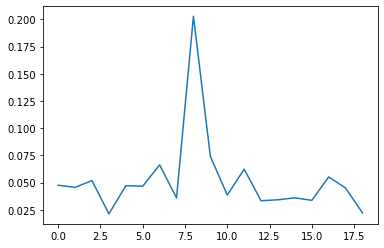

In [22]:

pd.Series(classifiers['GradientBoostingClassifier 12'].feature_importances_).plot()

In [23]:
classifiers['GradientBoostingClassifier 12'].feature_importances_

array([0.04759641, 0.04563821, 0.05183846, 0.02123748, 0.04712975,
       0.04671376, 0.06628728, 0.03592667, 0.20290501, 0.07423082,
       0.03855602, 0.06236419, 0.03332798, 0.03424086, 0.03602575,
       0.03371549, 0.05520863, 0.04499373, 0.02206349])